# FIne Tuning FLAN-T5 for text summarization

In [ ]:
!pip install nltk
!pip install datasets
!pip install transformers[torch]
!pip install tokenizers
!pip install evaluate
!pip install rouge_score
!pip install huggingface_hub

In [ ]:
pip install sentencepiece wandb accelerate -U 

# Data Preparation

### Prepare the dataset by filtering duplicates and empty data rows

In [2]:
import wandb
import nltk
import json
from pprint import pprint
import evaluate
import torch
import numpy as np
from datasets import load_dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoModelForSeq2SeqLM

In [3]:
# Load the tokenizer, model, and data collator
MODEL_NAME = "google/flan-t5-small"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model =  AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
def filter_and_update_dataset(file_path):
    """
    Filters out input-ideal pairs where 'ideal' summary is either missing or contains fewer than 10 words.
    Writes the filtered dataset back to a new JSONL file named 'data_clean.jsonl'.
    
    Args:
    - file_path (str): The path to the original JSONL file.
    
    Returns:
    - None: Writes the filtered dataset to 'data_clean.jsonl'.
    """
    valid_data = []
    unique_data = set()
    empty_rows = 0
    duplicate_rows = 0
    deleted_due_to_emptiness = []
    deleted_due_to_duplicates = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            if 'input' in data and 'ideal' in data and len(data['ideal'].split()) >= 10:
                if (data['input'], data['ideal']) not in unique_data:
                    valid_data.append(data)
                    unique_data.add((data['input'], data['ideal']))
                else:
                    duplicate_rows += 1
                    deleted_due_to_duplicates.append(data)
            else:
                empty_rows += 1
                deleted_due_to_emptiness.append(data)
    
    with open('data_clean.jsonl', 'w', encoding='utf-8') as outfile:
        for item in valid_data:
            json.dump(item, outfile)
            outfile.write('\n')
    valid_data = [json.dumps(item) for item in valid_data]
    
    pprint(f"Filtered {empty_rows} empty rows and {duplicate_rows} duplicate rows.")
    pprint(f"Deleted due to emptiness: {deleted_due_to_emptiness}")
    pprint(f"Deleted due to duplicates: {deleted_due_to_duplicates}")
    pprint(f"Total number of training data rows: {len(valid_data)}")


file_path = 'data.jsonl'
filter_and_update_dataset(file_path)



'Filtered 16 empty rows and 31 duplicate rows.'
("Deleted due to emptiness: [{'input': 'Sign in\\n Sponsored Channels\\nSign "
 'in\\nWelcome!Log into your account\\n\\nyour username\\n\\nyour '
 'password\\n\\nForgot your password\\nPassword recovery\\n\\nRecover your '
 'password\\n\\nyour email\\nSearch\\n Deep Dive \\n Three ways digital twins '
 'can optimize Open RAN 5G networks \\n! Image courtesy of 123.RF.\\n\\n# '
 'Three ways digital twins can optimize Open RAN 5G networks \\n\\nByDuc To, '
 'Principal System Architect, CTO Office, Rakuten Symphony & Kexuan Sun, '
 'Principal Wireless Architect, CTO Office, Rakuten Symphony\\n\\nJanuary 30, '
 '2024\\n\\n RAN Forum\\nAs 5G mobile networks grow in complexity, its '
 'becoming impossible for human network engineers to manage the network '
 'without automation. The evolution from rules-based automation to the use of '
 'AIML is creating a category of management solutions that can anticipate '
 'problems in the network and fix t

## Creating a workable DatasetDict object from the jsonl 

In [5]:
# Create and Split dataset
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

def create_and_split_dataset(jsonl_file_path, test_size=0.2):
    # Load the data from the JSONL file into a pandas DataFrame
    instruction_dataset_df = pd.read_json(jsonl_file_path, lines=True)

    # Split the DataFrame into training and testing sets
    train_df, test_df = train_test_split(instruction_dataset_df, test_size=test_size)

    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Create a DatasetDict
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'test': test_dataset
    })

    print(f"Training set size: {len(train_dataset)}")
    print(f"Testing set size: {len(test_dataset)}")
    
    
    pprint(dataset_dict)
    return dataset_dict

dataset_dict = create_and_split_dataset("data_clean.jsonl", test_size=0.2)

save_directory = "datasets/raw"
dataset_dict.save_to_disk(save_directory)

Training set size: 100
Testing set size: 26
DatasetDict({
    train: Dataset({
        features: ['input', 'ideal', '__index_level_0__'],
        num_rows: 100
    })
    test: Dataset({
        features: ['input', 'ideal', '__index_level_0__'],
        num_rows: 26
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/26 [00:00<?, ? examples/s]

# Analyze the data

In [6]:
def analyze_data(dataset_dict):
    import pandas as pd

    input_len = [len(x['input'].split()) for x in dataset_dict['train']]
    summary_len = [len(x['ideal'].split()) for x in dataset_dict['train']]
    

    
    data = pd.DataFrame([input_len, summary_len]).T
    data.columns = ['Input Length', 'Summary Length']

    
    average_input_length = data['Input Length'].mean()
    average_summary_length = data['Summary Length'].mean()

    print(f"Average input length: {average_input_length}")
    print(f"Average summary length: {average_summary_length}")

    
    data.hist(figsize=(15,5))


In [7]:
def measure_token_lengths(batch):
    # Tokenize without converting to tensors
    input_encodings = tokenizer(batch['input'], add_special_tokens=True, return_tensors=None)
    label_encodings = tokenizer(batch['ideal'], add_special_tokens=True, return_tensors=None)

    # Measure lengths
    input_lengths = [len(enc) for enc in input_encodings['input_ids']]
    label_lengths = [len(enc) for enc in label_encodings['input_ids']]

    
    return {"tokenized_input_lengths": input_lengths, "tokenized_label_lengths": label_lengths}


dataset_tokenized_analysis = dataset_dict.map(measure_token_lengths, batched=True)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (7386 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/26 [00:00<?, ? examples/s]

    input_lengths
0            7386
1            7673
2            1635
3            1303
4             905
..            ...
95           2336
96           1607
97           7921
98           1403
99           1896

[100 rows x 1 columns]
    label_lengths
0             476
1             406
2             349
3             347
4             332
..            ...
95            401
96            390
97            402
98            359
99            325

[100 rows x 1 columns]


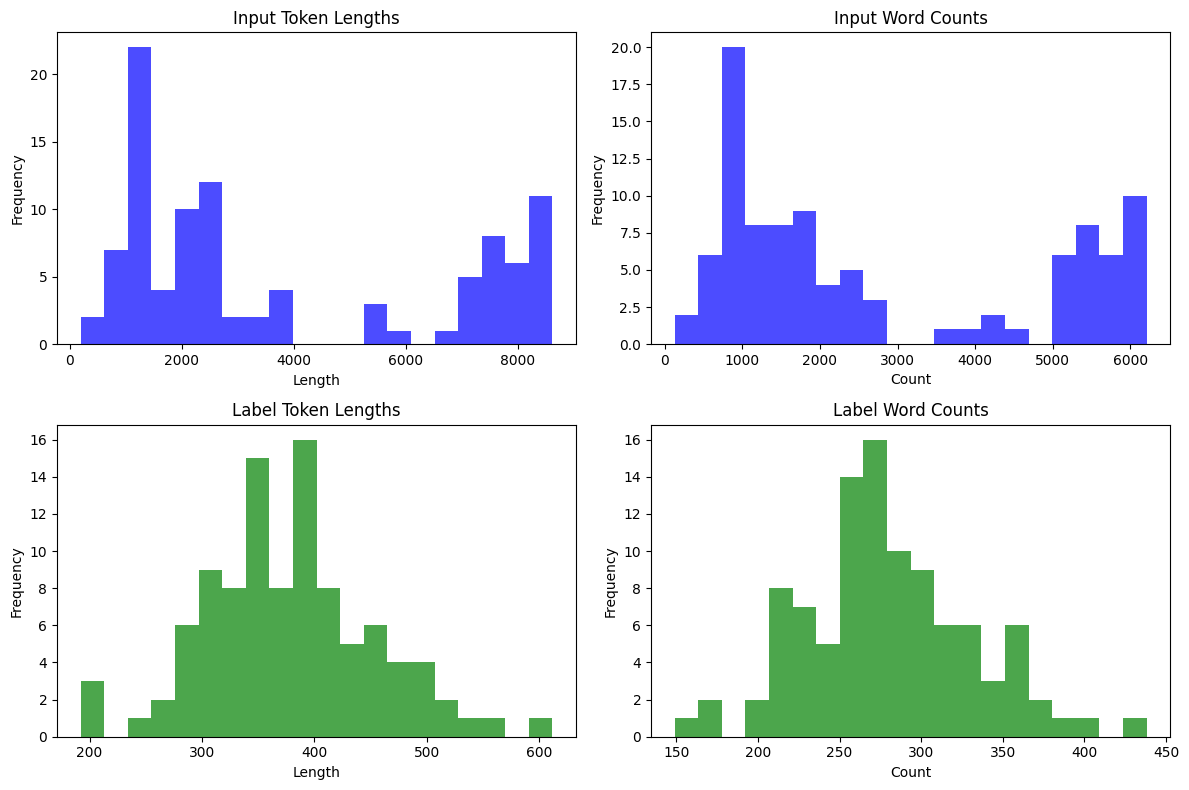

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_token_and_word_lengths(dataset):
    # Extract input and label token lengths
    input_lengths = dataset['train']['tokenized_input_lengths']
    label_lengths = dataset['train']['tokenized_label_lengths']
    
    # Create DataFrames for token lengths
    input_lengths_df = pd.DataFrame({'input_lengths': input_lengths})
    label_lengths_df = pd.DataFrame({'label_lengths': label_lengths})
    print(input_lengths_df)
    print(label_lengths_df)
    # Get word counts for input and labels
    input_word_counts = [len(x['input'].split()) for x in dataset['train']]
    label_word_counts = [len(x['ideal'].split()) for x in dataset['train']]
    
    # Plot token lengths and word counts
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    axs[0, 0].hist(input_lengths_df['input_lengths'], bins=20, color='blue', alpha=0.7)
    axs[0, 0].set_title('Input Token Lengths')
    axs[0, 0].set_xlabel('Length')
    axs[0, 0].set_ylabel('Frequency')
    
    axs[0, 1].hist(input_word_counts, bins=20, color='blue', alpha=0.7)
    axs[0, 1].set_title('Input Word Counts')
    axs[0, 1].set_xlabel('Count')
    axs[0, 1].set_ylabel('Frequency')
    
    axs[1, 0].hist(label_lengths_df['label_lengths'], bins=20, color='green', alpha=0.7)
    axs[1, 0].set_title('Label Token Lengths')
    axs[1, 0].set_xlabel('Length')
    axs[1, 0].set_ylabel('Frequency')
    
    axs[1, 1].hist(label_word_counts, bins=20, color='green', alpha=0.7)
    axs[1, 1].set_title('Label Word Counts')
    axs[1, 1].set_xlabel('Count')
    axs[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_token_and_word_lengths(dataset_tokenized_analysis)

In [9]:
import pandas as pd

def summarize_dataset(dataset):
    # Input token lengths
    input_token_lengths = dataset['train']['tokenized_input_lengths']
    input_token_lengths_df = pd.DataFrame({'input_token_lengths': input_token_lengths})
    print("Input Token Lengths Summary:")
    print(input_token_lengths_df.describe())

    # Input word counts
    input_word_counts = [len(x['input'].split()) for x in dataset['train']]
    input_word_counts_df = pd.DataFrame({'input_word_counts': input_word_counts})
    print("\nInput Word Counts Summary:")
    print(input_word_counts_df.describe())


summarize_dataset(dataset_tokenized_analysis)


Input Token Lengths Summary:
       input_token_lengths
count           100.000000
mean           4005.100000
std            2913.716186
min             197.000000
25%            1400.250000
50%            2615.500000
75%            7386.000000
max            8617.000000

Input Word Counts Summary:
       input_word_counts
count          100.00000
mean          2875.97000
std           2034.87528
min            127.00000
25%           1048.00000
50%           1996.00000
75%           5142.00000
max           6209.00000


In [10]:
import numpy as np

input_token_lengths = dataset_tokenized_analysis['train']['tokenized_input_lengths']

def calculate_token_percentage(input_token_lengths):
    # Percentage of inputs below 1024 tokens
    below_1024 = np.sum(np.array(input_token_lengths) < 1024) / len(input_token_lengths) * 100
    print(f"\nPercentage of inputs below 1024 tokens: {below_1024:.2f}%")

    # Percentage of inputs above 1024 tokens
    above_1024 = np.sum(np.array(input_token_lengths) >= 1024) / len(input_token_lengths) * 100
    print(f"Percentage of inputs above 1024 tokens: {above_1024:.2f}%")


calculate_token_percentage(input_token_lengths)



Percentage of inputs below 1024 tokens: 8.00%
Percentage of inputs above 1024 tokens: 92.00%


# Tokenize the inputs

In [11]:
prefix = "Summarize the following document: "


def preprocess_function(examples):
   inputs = [prefix + doc for doc in examples["input"]]
   
   model_inputs = tokenizer(inputs, max_length=800, truncation=True)
  
   labels = tokenizer(text_target=examples["ideal"], 
                      max_length=512,         
                      truncation=True)

   model_inputs["labels"] = labels["input_ids"]
   return model_inputs

In [12]:
tokenized_dataset = dataset_dict.map(preprocess_function, batched=True)
#tokenized_dataset

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

In [17]:
#save tokenized_dataset for evaluation in different environment 
save_directory = "datasets/tokenized"

# Save the DatasetDict to disk
tokenized_dataset.save_to_disk(save_directory)

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/26 [00:00<?, ? examples/s]

# Evaluation setup

In [13]:

import evaluate
import nltk
from datasets import load_metric

metric = evaluate.load('rouge')


## We will use rouge Metric, more specifically we will focus on rouge2 <=> calculating bigrams 

#### define compute_metrics function that will be used during training for evaluation 

In [14]:
def compute_metrics(eval_preds):
   preds, labels = eval_preds

   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

   result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

  
   return result


# Train

## Hyperparameters sweep

try hyperparameter sweep using Bayes search optimization

In [10]:
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)  
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA L4


In [18]:
import wandb
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# Define default hyperparameters
DEFAULT_HYPERPARAMETERS = {
    'learning_rate': 1e-5,
    'per_device_train_batch_size': 1,
    'per_device_eval_batch_size': 1,
    'weight_decay': 0.01,
    'save_total_limit': 2,
    'num_train_epochs': 5,
    'gradient_accumulation_steps': 3,
}

def train():
    # Initialize a wandb run, using default hyperparameters updated with any configs from the sweep
    run = wandb.init(project="FLAN-T5-small-FineTune", config=DEFAULT_HYPERPARAMETERS, reinit=True, mode="online")

    training_args = Seq2SeqTrainingArguments(
        output_dir=f"./results/{run.name}",
        evaluation_strategy="epoch",
        logging_strategy='epoch',
        logging_steps=1,
        learning_rate=run.config['learning_rate'],
        per_device_train_batch_size=run.config['per_device_train_batch_size'],
        per_device_eval_batch_size=run.config['per_device_eval_batch_size'],  
        weight_decay=run.config['weight_decay'],
        save_total_limit=run.config['save_total_limit'],
        num_train_epochs=run.config['num_train_epochs'],
        warmup_steps=4,
        predict_with_generate=True,
        push_to_hub=False,
        save_steps=10,
        log_level='info',
        report_to="wandb",
        gradient_accumulation_steps=run.config['gradient_accumulation_steps'],
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()

    trainer.save_model()
    tokenizer.save_pretrained(f"./results/{run.name}")
    
    run.finish()

sweep_config = {
    'method': 'bayes',  
    'metric': {
        'name': 'rouge2',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 1e-5,
            'max': 5e-4
        },
        'per_device_train_batch_size': {
            'values': [1, 2, 4]
        },
        'num_train_epochs': {
            'values': [3, 5, 7]
        },
        'weight_decay': {
            'values': [0.0, 0.01, 0.03]
        },
        'gradient_accumulation_steps': {
            'values': [1, 4, 8]
        }
    }
}

# Decide if a sweep is to be used
USE_SWEEP = False

if USE_SWEEP:
    sweep_id = wandb.sweep(sweep_config, project="Fine-Tune-FlanT5-small-Bayes")
    wandb.agent(sweep_id, train)
else:
    train()


PyTorch: setting up devices
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: ideal, __index_level_0__, input. If ideal, __index_level_0__, input are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. p

Saving model checkpoint to ./results/comic-pond-13/checkpoint-10
Configuration saved in ./results/comic-pond-13/checkpoint-10/config.json
Configuration saved in ./results/comic-pond-13/checkpoint-10/generation_config.json
Model weights saved in ./results/comic-pond-13/checkpoint-10/model.safetensors
tokenizer config file saved in ./results/comic-pond-13/checkpoint-10/tokenizer_config.json
Special tokens file saved in ./results/comic-pond-13/checkpoint-10/special_tokens_map.json
added tokens file saved in ./results/comic-pond-13/checkpoint-10/added_tokens.json
Saving model checkpoint to ./results/comic-pond-13/checkpoint-20
Configuration saved in ./results/comic-pond-13/checkpoint-20/config.json
Configuration saved in ./results/comic-pond-13/checkpoint-20/generation_config.json
Model weights saved in ./results/comic-pond-13/checkpoint-20/model.safetensors
tokenizer config file saved in ./results/comic-pond-13/checkpoint-20/tokenizer_config.json
Special tokens file saved in ./results/com

In [ ]:
%wandb

# Evaluate Fine tuned model

### Create a prompt for testing

In [11]:
prompt = tokenizer.decode(tokenized_dataset['test']['input_ids'][22])
prompt

'Summarize the following document: ServicesGermany--Dynamics 365 GermanyAustralia--AX Integration Australia--Dynamics 365 AustraliaUnited Kingdom--AX Integration--AX MobilityIndustries--Animal Management--Food & Agriculture--Retail & Ecommerce--PartnerDynamics 365--Dynamics Business Central--Microsoft Dynamics 365--Dynamics 365 Implementation--Dynamics 365 Ecommerce--Dynamics 365 Migration--Dynamics 365 Applications--FastTrack HR Payroll--FastTrack Finance & OperationsMobile Apps--Microsoft Dynamics AX CRM Mobile App--AX D365 Workflow Approvals App--AX D365 Warehouse Management App--AX D365 2012 Timesheet App--AX D365 2012 Expenses AppConnectors--Magento Connector--Shopify Connector--WooCommerce Connector--Amazon Connector--Salesforce Connector--Ebay ConnectorAX DevelopmentAX CustomizationAX IntegrationAX Business IntelligenceAX Loyalty Management Solution--AX Loyalty Management AppDynamics NAVD365 Integration--Dynamics NAV Magento--Dynamics NAV ShopifyTroubled Implementation--Dynamics

### Use  Pre- Trained model

In [12]:
model =  AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

inputs_pretrained = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=300)
output_pretrained = model.generate(**inputs_pretrained,min_length=200, early_stopping=False, no_repeat_ngram_size=2, max_length = 600)
answer_pretrained = tokenizer.decode(output_pretrained[0], skip_special_tokens=True)

In [13]:
answer_pretrained

'Software and services of the company. Software, services and products of a company, company or company based in Germany. - Software & services for ecommerce, retail, and retail. Services and product and service of services. Products and Services of companies. Product and Service of products and/or services. Service and Product of service. Company. product of company and company in the world. Customer. service and customer service in europe. Country. country. region.. continent., continent, region, country, nation, state, federation, united kingdom. United Kingdom. Europe. America. Africa. Asia. Australia. Canada. China. India. Russia. Japan. France. Germany, Canada, United States. Spain. Italy. Switzerland. Sweden. Denmark. Ireland. Netherlands. Poland. Portugal. Romania. Austria. Belgium. Hungary. Greece. Turkey. Ukraine. USA. Mexico. Brazil. Argentina. Chile. Colombia. Venezuela. Iran.'

#Apply FT model

In [62]:
last_checkpoint_ft_small = "./results/comic-pond-13/checkpoint-160/"

In [14]:

finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint_ft_small)
tokenizer = T5Tokenizer.from_pretrained(last_checkpoint)

inputs_ft = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=500)
output_ft = finetuned_model.generate(**inputs_ft,  min_length=200, early_stopping=False, no_repeat_ngram_size=2, max_length = 600)
answer_ft = tokenizer.decode(output_ft[0], skip_special_tokens= True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
pprint(answer_ft)

('This document is a document titled "What Is the Primary Goal Of Business '
 'Continuity Planning" by Microsoft. It discusses business continuity '
 'planning, including the primary goal of achieving business continuity. The '
 'document discusseses the importance of business succession planning and the '
 'role of the company in ensuring that business is managed efficiently and '
 'efficiently. Key points from the document include: - The primary objective '
 'of Business continuity is to ensure that businesses are managed effectively '
 'and effectively. – The main objective is the business leadership strategy, '
 'which includes the management of businesses, the development of companies, '
 "and implementing companies' policies. In conclusion, this document provides "
 'supplemental information on business management and business planning. This '
 'includes identifying the key points of key business objectives, establishing '
 "efficiencies, improving business processes, managing bu

In [16]:
from rouge_score import rouge_scorer
import json

def compare_rouge_scores(answer1, answer2, label, key1str="Answer 1", key2str="Answer 2"):
    scorer = rouge_scorer.RougeScorer(['rouge2', 'rouge2', 'rougeL'], use_stemmer=True)
    scores_answer1 = scorer.score(answer1, label)
    scores_answer2 = scorer.score(answer2, label)
    
    # Create a dictionary to store the scores
    scores_data = {
        key1str: {
            "ROUGE-2": scores_answer1['rouge2']
        },
        key2str: {
            "ROUGE-2": scores_answer2['rouge2']
        }
    }
    
    # Print the scores in a visually appealing format
    print(json.dumps(scores_data, indent=4))
    
    return scores_answer1, scores_answer2

In [81]:
from textwrap import fill

def generate_output(prompt, model, tokenizer):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=200)

    # Generate the output
    outputs = model.generate(**inputs, min_length=200, early_stopping=False, no_repeat_ngram_size=2, max_length = 600)
    #print(f"model is {model}")
    # Decode the output
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #print(f"Generate output outputed this: {answer}")
    return answer

from textwrap import fill
import json

def visualize_outputs(answer1, answer2, key1str: str, key2str: str):
    output_data = {
        "{key1str}Model Output": fill(answer1, width=80),
        "{key2str} Model Output": fill(answer2, width=80)
    }

    print(json.dumps(output_data, indent=4))


In [82]:
from rouge_score import rouge_scorer
from textwrap import fill

def evaluate_models(prompt, answer1, answer2, ideal, key1str: str, key2str: str):
    # Generate the output using the fine-tuned model
    #fine_tuned_answer = generate_output(prompt, finetuned_model, tokenizer)
    #pre_trained_answer = generate_output(prompt, model_pretrained, tokenizer)
    # Visualize the outputs
    visualize_outputs(fine_tuned_answer, pre_trained_answer, key1str, key2str)

    # Compare the ROUGE scores
    scores = compare_rouge_scores(fine_tuned_answer, pre_trained_answer, ideal, key1str, key2str)

    return scores

In [19]:
model_pretrained =  AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
finetuned_model = T5ForConditionalGeneration.from_pretrained(last_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dynamic truncation of inputs

### Now, lets experiment with truncating inputs based on its relevance to summary 

In [19]:
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# NLTK's punkt tokenizer 
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Segmentating text

In [20]:
def segment_texts(example):
    # This function takes a single example and returns it with added 'sentences' key
    example['input_sentences'] = sent_tokenize(example['input'])
    return example

# Apply the segmentation function to each dataset in the DatasetDict
for split in dataset_dict.keys():
    dataset_dict[split] = dataset_dict[split].map(segment_texts)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

In [21]:
dataset_dict['train']['input_sentences'][0]

['Go to TMFORUM.ORG\n\nLogin\n\nRegister\n Research & Analysis\n Webinars & Podcasts\n2024 TM Forum\nJoanne Taaffe\n\nEditor in Chief\n\nTimothy Edwards\n\nCommercial Manager\n\nArticle , , , , \n\n# How Verizon is using digital twins to reduce energy costs\n\n!Joanne Taaffe\n\n03 Jan 2023\n\n!',
 'How Verizon is using digital twins to reduce energy costs\n\nOperators are striving to use technology to improve the energy efficiency of their networks as we showcased in our recent report .',
 'Verizon, for example, has been able to reduce energy costs by over $100 million a year by using network digital twins to build energy consumption models, according to Shankar Arumugavelu, Chief Digital and Information Officer, \n\nThe creation of network digital twins is part of a long-term investment by Verizon in advanced analytics that will help it optimize network investments based on total cost of ownership, while improving customer experience.',
 'Michael Raj, Vice President of Network Enablem

## Calculate Relevance Scores


### calculate the TF-IDF scores for each sentence against the summary to find their relevance. Use these scores to select the most relevant sentences.

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

 high weight of the tf-idf calculation is reached when we have a high term frequency(tf) in the given document(local parameter) and a low document frequency of the term in the whole collection ( global parameter).

Fit transform: 

Documents/Terms | word1 | word2 | ... | wordN
----------------|-------|-------|-----|------
Sentence 1      | TF-IDF| TF-IDF| ... | TF-IDF
Sentence 2      | TF-IDF| TF-IDF| ... | TF-IDF
...             | ...   | ...   | ... | ...
Sentence N      | TF-IDF| TF-IDF| ... | TF-IDF
Summary         | TF-IDF| TF-IDF| ... | TF-IDF

Cosine Similarity= 
∥A∥∥B∥/
A⋅B
​


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Each element in this list corresponds to a cosine similarity score between the summary and one of the sentences.

Calculate the score of relevance for a single input row. Each element of the list translate the relevance of the 'input_sentence' to the summary. 
For example sentence: 
- 'White Paper\nSimplifying 5G with the Network Digital Twin\nIntroduction\nAs telecommunications technology transitions from 4G \nto the incredible promise and potential of 5G, one thing \nis clear the new technology is not just an incremental \nupgrade, but an exponential leap in terms of speed, \naccuracy, latency and complexity.' 

has a score of relevance = 0.25726445454798286 

In [25]:
def calculate_relevance(example):
    # Initialize the vectorizer here
    vectorizer = TfidfVectorizer(stop_words='english')
    
    # Combine sentences and the ideal summary into one list for TF-IDF
    combined_text = example['input_sentences'] + [example['ideal']]
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    
    # Compute cosine similarity between the summary and each sentence
    similarity_scores = cosine_similarity(tfidf_matrix[-1:], tfidf_matrix[:-1]).flatten()
    
    return {"relevance_scores": similarity_scores.tolist()}

#Apply the function to each dataset in the DatasetDict using map
for split in dataset_dict.keys():
    dataset_dict[split] = dataset_dict[split].map(calculate_relevance, batched=False)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

In [27]:
dataset_dict['train']['relevance_scores']

[[0.0,
  0.0,
  0.0,
  0.36849788336188793,
  0.2164105781470119,
  0.013410169843403427,
  0.13931692402983886,
  0.20024924528564894,
  0.32774957395113,
  0.2436468428622164,
  0.13754007274595284,
  0.15695229884433937,
  0.10437783859810357,
  0.10702437017900009,
  0.22771861173288144,
  0.20016398255292062,
  0.26109087747148496,
  0.3566198672257921,
  0.14279800731807107,
  0.0,
  0.13208149439055172,
  0.1914720970513053,
  0.05672969547956985,
  0.1351709504542801,
  0.07547436224692616,
  0.04166812504898319,
  0.0,
  0.2735849293618645,
  0.04689047301658293,
  0.03739870959033941,
  0.02293198430197503,
  0.12253115334954319,
  0.0,
  0.112651717963158,
  0.03454220178820073,
  0.0,
  0.1935796941048174,
  0.024549319345270847,
  0.08034153095210397,
  0.07598206931094383,
  0.0,
  0.2381276806562938,
  0.09172233873371402,
  0.051268505709146345,
  0.0,
  0.20759490992495055,
  0.0516694647015642,
  0.11192179016928427,
  0.08020798257296764,
  0.11430548152939013,
  0.0

## Filter and Select Sentences

Identify and select the sentences that have the highest relevance to the summary based on the computed similarity scores.

We choose top-k strategy of picking top-k relevant ( top k sentences with the max relevance scores)

In [28]:
# Check the length of 'input_sentences' in the 'train' split
input_sentences_length = len(dataset_dict['train']['input_sentences'])
print("Length of 'input_sentences' in 'train' split:", input_sentences_length)

# Check the length of 'relevance_scores' in the 'train' split
relevance_scores_length = len(dataset_dict['train']['relevance_scores'])
print("Length of 'relevance_scores' in 'train' split:", relevance_scores_length)

Length of 'input_sentences' in 'train' split: 100
Length of 'relevance_scores' in 'train' split: 100


In [22]:
def select_top_k_sentences_preserving_order(document, k=5):
    sentences = document['input_sentences']
    scores = document['relevance_scores']
    seen = set()

    try:
        
        top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        
        selected_sentences = []
        for index in top_indices:
            if len(selected_sentences) >= k:
                break
            sentence = sentences[index]
            if sentence not in seen:
                seen.add(sentence)
                selected_sentences.append(sentence)

        # Combine selected sentences into a single string
        truncated_input = ' '.join(selected_sentences)
        return {'truncated_input': truncated_input}
    except Exception as e:
        error_message = f"An error occurred: {e}"
        print(error_message)
        return {'truncated_input': ''}  

## MEAN K 

Calculate mean K, to geti insight on which value to use while filtering the dataset 

In [23]:
# Calculate the lengths of each inner list
lengths = [len(inner_list) for inner_list in dataset_dict['train']['input_sentences']]

# Calculate the mean value
mean_length = sum(lengths) / len(lengths)

print("Mean length of inner lists:", mean_length)

Mean length of inner lists: 129.35


In [26]:
k_value = 120
# Apply the function to both the train and test splits
for split in dataset_dict.keys():
    dataset_dict[split] = dataset_dict[split].map(
        lambda example: select_top_k_sentences_preserving_order(example, k=k_value),
        batched=False
    )

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

In [32]:
dataset_dict['train']['input']

['! \n Resources\nEnglish\n ! \n\nEnglish\n Resources\n!\n\n# 5 challenges in setting up 5G private networks and how to overcome them\n5G is revolutionizing operations, offering high-speed , low- latency connectivity that improves real-time communication and enables seamless connectivity for businesses and cities alike. With dedicated infrastructure and localized coverage, 5G private networks provide greater reliability and security than public or traditional wireless networks. \n\nThey are becoming increasingly important in the digital transformation of and where a vast number of connected devices need to interact seamlessly. \n\nWhile private 5G networks have shown to be a pivotal solution for numerous businesses, it requires an initial investment of time, resources, and capital. The journey to building a wireless network is filled with challenges, including coverage, spectrum allocation, security, and more. \n\nIn this article, we will explore some major challenges of deploying 5G p

In [33]:
dataset_dict['train']['truncated_input']

['# 5 challenges in setting up 5G private networks and how to overcome them\n5G is revolutionizing operations, offering high-speed , low- latency connectivity that improves real-time communication and enables seamless connectivity for businesses and cities alike. Lean on wireless network experts\n## Challenges of private network planning & design \n\nDecades of assisting businesses in planning and deploying private networks have allowed Siradel to get acquainted with various indoor and outdoor environments and identify the major roadblocks in setting up 5G private networks. In this article, we will explore some major challenges of deploying 5G private networks and share insights on how to overcome them, empowering you to navigate network design complexity and unlock the full potential of your private wireless network. Optimizing coverage and avoiding interference\n\n5G private networks are appealing due to the high-performance, security, and flexibility they provide. Wireless planning 

Comparison check

In [34]:
trunc_compar= dataset_dict['train']['truncated_input'][0]
orig_compar = dataset_dict['train']['input'][0]
orig_summary_compar = dataset_dict['train']['ideal'][0]

In [35]:
print(trunc_compar)


# 5 challenges in setting up 5G private networks and how to overcome them
5G is revolutionizing operations, offering high-speed , low- latency connectivity that improves real-time communication and enables seamless connectivity for businesses and cities alike. Lean on wireless network experts
## Challenges of private network planning & design 

Decades of assisting businesses in planning and deploying private networks have allowed Siradel to get acquainted with various indoor and outdoor environments and identify the major roadblocks in setting up 5G private networks. In this article, we will explore some major challenges of deploying 5G private networks and share insights on how to overcome them, empowering you to navigate network design complexity and unlock the full potential of your private wireless network. Optimizing coverage and avoiding interference

5G private networks are appealing due to the high-performance, security, and flexibility they provide. Wireless planning software

In [36]:
print(orig_compar)

! 
 Resources
English
 ! 

English
 Resources
!

# 5 challenges in setting up 5G private networks and how to overcome them
5G is revolutionizing operations, offering high-speed , low- latency connectivity that improves real-time communication and enables seamless connectivity for businesses and cities alike. With dedicated infrastructure and localized coverage, 5G private networks provide greater reliability and security than public or traditional wireless networks. 

They are becoming increasingly important in the digital transformation of and where a vast number of connected devices need to interact seamlessly. 

While private 5G networks have shown to be a pivotal solution for numerous businesses, it requires an initial investment of time, resources, and capital. The journey to building a wireless network is filled with challenges, including coverage, spectrum allocation, security, and more. 

In this article, we will explore some major challenges of deploying 5G private networks an

In [37]:
print(orig_summary_compar)

This document discusses the challenges involved in setting up 5G private networks and provides insights on how to overcome them. 5G private networks offer high-speed, low-latency connectivity that improves real-time communication and enables seamless connectivity for businesses and cities. However, there are several challenges in deploying these networks, including obtaining the right frequency band, optimizing coverage and avoiding interference, adapting to indoor and outdoor environments, integrating with existing infrastructure, and meeting regulation requirements.

To address these challenges, the document suggests the following steps:

1. Use high-precision 3D building models to understand the local environment and optimize network architecture.
2. Utilize wireless planning software to assess and simulate network performance, considering different technologies and frequencies.
3. Seek the expertise of wireless network experts for customized support, including guidance on regulator

Validate 

In [38]:
scores_trunc, scores_orig = compare_rouge_scores(trunc_compar, orig_compar, orig_summary_compar, "truncated_scores", "original_scores")

{
    "truncated_scores": {
        "ROUGE-2": [
            0.5645161290322581,
            0.08771929824561403,
            0.15184381778741868
        ]
    },
    "original_scores": {
        "ROUGE-2": [
            0.5685483870967742,
            0.08829054477144646,
            0.15284552845528454
        ]
    }
}


#### From the comparison we can see that the truncation strategy did not improve evaluation much, what still might benefit in the training process

## Visualize updated dataset

In [27]:
# Example code to print out the updated dataset content
for split in dataset_dict.keys():
    print(f"Showing updated inputs from the {split} split:")
    for example in dataset_dict[split].select(range(2)):  # Adjust range as needed
        print("Document Sentences:")
        for sentence in example['input_sentences']:
            print(sentence)
        print("======================")

Showing updated inputs from the train split:
Document Sentences:
Go to TMFORUM.ORG

Login

Register
 Research & Analysis
 Webinars & Podcasts
2024 TM Forum
Joanne Taaffe

Editor in Chief

Timothy Edwards

Commercial Manager

Article , , , , 

# How Verizon is using digital twins to reduce energy costs

!Joanne Taaffe

03 Jan 2023

!
How Verizon is using digital twins to reduce energy costs

Operators are striving to use technology to improve the energy efficiency of their networks as we showcased in our recent report .
Verizon, for example, has been able to reduce energy costs by over $100 million a year by using network digital twins to build energy consumption models, according to Shankar Arumugavelu, Chief Digital and Information Officer, 

The creation of network digital twins is part of a long-term investment by Verizon in advanced analytics that will help it optimize network investments based on total cost of ownership, while improving customer experience.
Michael Raj, Vice Presi

Now, after we truncated input data, we check if the perfomance of the FT model is increased

# Fine Tuning with bigger model

In [ ]:
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)  
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")

In [28]:
model_flan_t5_base='google/flan-t5-base'

model_base = AutoModelForSeq2SeqLM.from_pretrained(model_flan_t5_base, torch_dtype=torch.bfloat16)
tokenizer = T5Tokenizer.from_pretrained(model_flan_t5_base)
model_base

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [29]:
# Define the preprocessing function
def preprocess_function(examples):
    # We prefix our tasks with "answer the question"
    prefix = "Summarize the following document: "

    # Tokenize the inputs
    inputs = [prefix + doc for doc in examples["truncated_input"]]
    model_inputs = tokenizer(inputs, max_length=800, truncation=True, padding=True)

    # The "labels" are the tokenized outputs
    labels = tokenizer(examples["ideal"], max_length=512, truncation=True, padding = True)

    # Update the model inputs with the labels
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

# Apply the preprocess_function to the training and testing datasets
tokenized_dataset = dataset_dict.map(preprocess_function, batched=True)
path_to_save = "datasets/tokenized/truncated"
# Save the tokenized dataset
tokenized_dataset.save_to_disk(path_to_save)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/26 [00:00<?, ? examples/s]

## Setup the PEFT/LoRA model for Fine-Tuning


In [ ]:
pip install peft

In [30]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer


lora_config = LoraConfig(
    r=32, 
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM 
)

In [31]:
peft_model = get_peft_model(model_base, 
                            lora_config)
peft_model.print_trainable_parameters()

trainable params: 3,538,944 || all params: 251,116,800 || trainable%: 1.4092820552029972


In [32]:
import time
PEFT_VERSION = 2

output_dir = f'results/PEFT-FLANT5-base-{PEFT_VERSION}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1,
    logging_steps=10,
    max_steps=500,
    log_level='info',
    report_to="wandb",
    logging_strategy="steps",
)
    
wandb.init(project="PEFT_FLANT5", config=peft_training_args)    

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,

)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: mbuloichykai (zarathustracz). Use `wandb login --relogin` to force relogin


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [52]:
peft_trainer.train()

peft_model_path="results/PEFT"

peft_model.save_pretrained(peft_model_path)  

The following columns in the training set don't have a corresponding argument in `PeftModelForSeq2SeqLM.forward` and have been ignored: input_sentences, relevance_scores, truncated_input, ideal, input, __index_level_0__. If input_sentences, relevance_scores, truncated_input, ideal, input, __index_level_0__ are not expected by `PeftModelForSeq2SeqLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 100
  Num Epochs = 39
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 3,538,944
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Saving model checkpoint to results/PEFT-FLANT5-base-2/checkpoint-500
loading configuration file config.json from cache at /home/zeus/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_pena

## Add adapter to the original head

In [55]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       'results/PEFT-FLANT5-base-2/checkpoint-500', 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

loading configuration file config.json from cache at /home/zeus/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/7bcac572ce56db69c1ea7c8af255c5d7c9672fc2/config.json
Model config T5Config {
  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_lengt

In [56]:
peft_model.save()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
            